In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error






plt.style.use('fivethirtyeight')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

# makes plots bigger
plt.rcParams["figure.figsize"] = (20,8)

In [2]:
from numpy import asarray
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.metrics import mean_absolute_error
import xgboost
from matplotlib import pyplot
from xgboost import XGBRegressor

In [3]:
df = pd.read_csv('GREATEC.csv')

df= df[['c','d','h','l','o','v']]

df.info()

df['d'] = pd.to_datetime(df['d'], dayfirst= True )

df.set_index('d',inplace=True,drop=True)

df.index.name = None

df

data = df.iloc[-200:]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   c       398 non-null    float64
 1   d       398 non-null    object 
 2   h       398 non-null    float64
 3   l       398 non-null    float64
 4   o       398 non-null    float64
 5   v       398 non-null    float64
dtypes: float64(5), object(1)
memory usage: 18.8+ KB


In [4]:
# forecast monthly births with xgboost
from numpy import asarray
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor
from matplotlib import pyplot

# transform a time series dataset into a supervised learning dataset
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols = list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
	# put it all together
	agg = concat(cols, axis=1)
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg.values

# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
	return data[:-n_test, :], data[-n_test:, :]

# fit an xgboost model and make a one step prediction
def xgboost_forecast(train, testX):
	# transform list into array
	train = asarray(train)
	# split into input and output columns
	trainX, trainy = train[:, :-1], train[:, -1]
	# fit model
	model = XGBRegressor(objective='reg:squarederror', n_estimators=1000)
	model.fit(trainX, trainy)
	# make a one-step prediction
	yhat = model.predict(asarray([testX]))
	return yhat[0]

# walk-forward validation for univariate data
def walk_forward_validation(data, n_test):
	predictions = list()
	# split dataset
	train, test = train_test_split(data, n_test)
	# seed history with training dataset
	history = [x for x in train]
	# step over each time-step in the test set
	for i in range(len(test)):
		# split test row into input and output columns
		testX, testy = test[i, :-1], test[i, -1]
		# fit model on history and make a prediction
		yhat = xgboost_forecast(history, testX)
		# store forecast in list of predictions
		predictions.append(yhat)
		# add actual observation to history for the next loop
		history.append(test[i])
		# summarize progress
		print('>expected=%.2f, predicted=%.2f' % (testy, yhat))
	# estimate prediction error
	error = mean_absolute_error(test[:, -1], predictions)
	return error, test[:, -1], predictions

In [5]:
data_in1_out_1 = series_to_supervised(data[['c']], n_in=1,n_out=1)

In [6]:
data_in1_out_1

array([[1.035, 1.175],
       [1.175, 1.12 ],
       [1.12 , 1.15 ],
       [1.15 , 1.105],
       [1.105, 1.14 ],
       [1.14 , 1.19 ],
       [1.19 , 1.145],
       [1.145, 1.175],
       [1.175, 1.14 ],
       [1.14 , 1.14 ],
       [1.14 , 1.25 ],
       [1.25 , 1.29 ],
       [1.29 , 1.305],
       [1.305, 1.355],
       [1.355, 1.375],
       [1.375, 1.34 ],
       [1.34 , 1.38 ],
       [1.38 , 1.375],
       [1.375, 1.36 ],
       [1.36 , 1.39 ],
       [1.39 , 1.365],
       [1.365, 1.425],
       [1.425, 1.43 ],
       [1.43 , 1.405],
       [1.405, 1.415],
       [1.415, 1.425],
       [1.425, 1.425],
       [1.425, 1.445],
       [1.445, 1.425],
       [1.425, 1.39 ],
       [1.39 , 1.385],
       [1.385, 1.36 ],
       [1.36 , 1.425],
       [1.425, 1.515],
       [1.515, 1.47 ],
       [1.47 , 1.45 ],
       [1.45 , 1.48 ],
       [1.48 , 1.57 ],
       [1.57 , 1.635],
       [1.635, 1.675],
       [1.675, 1.64 ],
       [1.64 , 1.7  ],
       [1.7  , 1.69 ],
       [1.6

In [15]:
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual)) 
    mape_1 = np.mean(np.abs((actual - forecast) / actual)) * 100# MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
   
    return({'mape':mape, 'mape_1':mape_1, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 
            'corr':corr})

In [16]:
forecast_accuracy(yhat, y)

{'mape': 0.027889425386530928,
 'mape_1': 2.788942538653093,
 'me': -0.09925402323404937,
 'mae': 0.14784738222757957,
 'mpe': -0.0186125015103026,
 'rmse': 0.20699655840016656,
 'corr': 0.9203477982061855}

In [17]:
data_latest = data[['c']].values

In [19]:
# transform the time series data into supervised learning
train = series_to_supervised(data_latest, n_in=1, n_out=1)
# split into input and output columns
trainX, trainy = train[:, :-1], train[:, -1]
# fit model
model = XGBRegressor(objective='reg:squarederror', n_estimators=1000)
model.fit(trainX, trainy)
# construct an input for a new preduction
row = data_latest[-1:].flatten()
# make a one-step prediction
yhat = model.predict(asarray([row]))
print('Input: %s, Predicted: %.3f' % (row, yhat[0]))

Input: [5.79], Predicted: 5.790


In [13]:
mae, y, yhat = walk_forward_validation(data_in1_out_1, 12)

C:\Users\Public\Documents\anaconda\lib\site-packages\xgboost\data.py:104: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


>expected=4.85, predicted=4.65
>expected=4.73, predicted=4.85
>expected=4.85, predicted=4.85
>expected=4.80, predicted=4.73
>expected=4.75, predicted=4.77
>expected=4.97, predicted=4.85
>expected=5.18, predicted=4.76
>expected=5.66, predicted=5.18
>expected=5.71, predicted=5.66
>expected=5.85, predicted=5.71
>expected=5.75, predicted=5.85
>expected=5.79, predicted=5.85


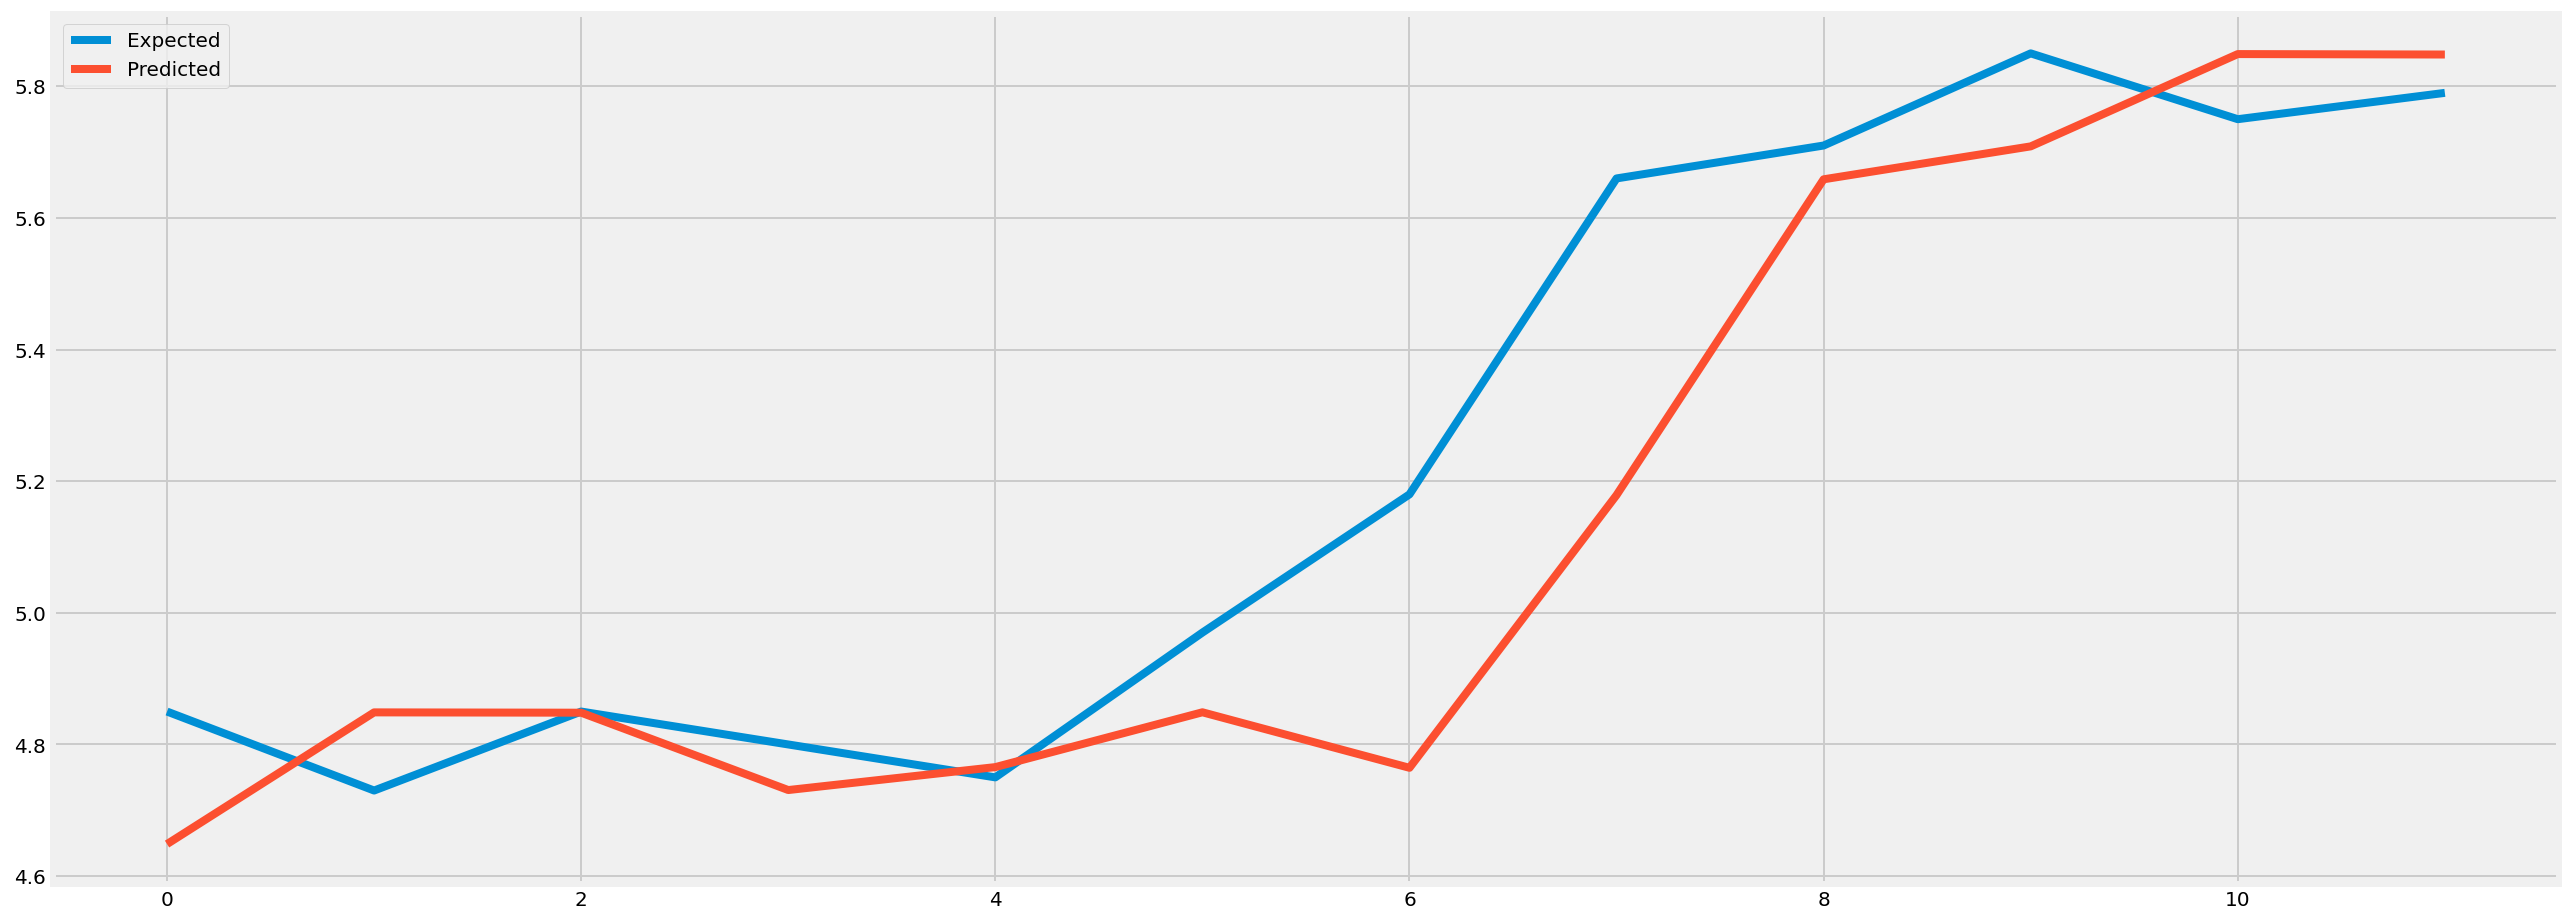

In [14]:
pyplot.plot(y, label='Expected')
pyplot.plot(yhat, label='Predicted')
pyplot.legend()
pyplot.show()